# 第一节：决策树模型

本节将首先介绍我们的要处理的高能物理实验中的分类问题。基于这一问题：

 - 我们首先用线性模型进行简单测试。
 - 我们练习使用 XGBoost 来训练 BDT 模型完成分类问题。

> 部分材料节选自[第一届 CMS 冬令营ML材料](https://github.com/PKU-Hep-Group/CMSWinterCampMLPart1)，特向stqian同学表示感谢。

**如果在 Google Colab 中使用，请首先运行下面的命令安装相关的python包。**

In [ ]:
! pip install uproot==4.2.2 pandas==1.3.4 mplhep weaver-core

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ROOT)

## CMS 分析中的分类任务：背景介绍

在大型强子对撞机（LHC）的高能物理的实验中，两束高能质子束构成一个个团簇流进行对撞，每个团簇发生的对撞称为一个**事例**。对撞会发生复杂的物理过程，产生新粒子——这由目前的量子场论理论可以解释。我们能够采集的信号的是这些产生的粒子与探测器相互作用后，获得的径迹信息、能量沉积信息等等。利用算法，我们可以把所有的末态粒子重建出来，进而知道它所对应的物理过程，转化为对撞机物理的一个重要的可观测量：一个物理过程的微分散射截面。通过比较实验测得的截面和理论预计的截面，我们可以精确测量一些量子场论的理论参数、寻找新粒子可能存在的迹象等等。

<img src="figures/HiggsEventDisplay.jpg" alt="Drawing" width=500/>

2012 年 Higgs 玻色子的发现补全了标准模型最后一块拼图，是粒子物理实验的一个里程碑。接下来一直延伸到高亮度LHC实验的一个重要的物理目标，是研究希格斯的自耦合 (self-coupling）性质。在标准模型中，电弱对称性破缺后，拉式量中会出现Higgs的自耦合项。对应到具体的物理过程，即出现三个或四个Higgs玻色子直接耦合的情形。一个典型的过程由下面的费曼图所示（这是产生双Higgs玻色子过程的一种费曼图）。

<img src="figures/DihiggsFD.jpg" alt="Drawing" width=300/>

这个过程中，由于Higgs的自耦合，最终产生了两个Higgs玻色子。如果能够测量这个过程的物理散射截面，那么便可以对自耦合的修正因子$\kappa_\lambda$进行限制。我们这里讨论一种特殊的衰变模式，即一个Higgs衰变到分支比最大的$b\bar{b}$末态，另一个Higgs衰变到$W^+W^-$。在本例中，我们将通过重建的事例信息，分辨双希格斯物理中的物理信号 $HH\to b\bar{b}W^+W^-$ 与其最大的本底过程$t\bar{t}\to b\bar{b}W^+W^-$。˙信号和本底过程有如下的特点：
- 二者的末态粒子完全相同：两个b夸克会形成两个b喷注；两个W玻色子研究其轻子化衰变，生成两个轻子（即电子或μ子）和看不⻅的中微子；
- 但二者的末态粒子的相空间稍有差别: $HH$ 和 $t\bar{t}$ 各自是头对头出射的（因极端相对论效应），所以前者 $bb$ 和 $WW$ 可能各自很近，后者两个 $bW$ 对可能各自很近；
- 我们可以实验上测出信号和背景的末态信息，即两个 b 喷注 + 两个轻子的信息（四动量、喷注性质的变量等等）。

那么，能否用神经网络技术，利用重建的事例信息区分两种过程？

<img src="figures/SigBkgFS.png" alt="Drawing" width=700/>

> 对于事例重建信息的说明：
>
> - 首先，在LHC上夸克（如底夸克）和胶子会最终形成喷注——它们是聚焦在一定半径的锥角内的一束能量很强的强子簇设。强相互作用在能标较高的情况下较弱，但在低能标下表现地非常强，夸克因紧闭效应无法单独存在，需与其它夸克紧密结合，形成强子无法“挣脱”。因此，夸克从最初的产生起即不断发生强子化和部分子淋浴过程，最终只能看到一束强子簇设。
> 
> - 其次，中微子无法被探测器观测到，但是因为它会带走一部分横动量，破坏横截面的动量守恒。因此，可以通过重建出横截面的丢失横动量和方位角，来判断过程中产生了中微子。


## 数据集介绍

我们的数据集包含上述的信号、背景两种物理过程的事例。
在储存的特征中，我们包含了两个b夸克形成喷注 (`bjet1_*`, `bjet2_*` 特征)，两个轻子对应的特征（`lep1_*`, `lep2_*`特征）和丢失横动量特征（`met_*`）。
下面用 `pandas` 数据分析包对所储存的数据以表格形式进行呈现。


我们首先把数据导入进来，并且看看分布长什么样吧

**如果在 Google Colab 中使用，请首先运行下面的命令下载所需数据集。**

In [ ]:
! if [[ "$(hostname)" != *pku.edu.cn* && "$(hostname)" != *lxlogin* ]]; then \
    wget https://coli.web.cern.ch/coli/share/cmschina/ML/dihiggs_ntuples/hh2b2w.root; \
    wget https://coli.web.cern.ch/coli/share/cmschina/ML/dihiggs_ntuples/ttbar.root; \
fi

In [2]:
# Load data

import os
# Determine the base directory and the remote git path
hostname = os.uname()[1]
if 'pku.edu.cn' in hostname: # on PKU cluster
    basedir = '/data/pubfs/pku_visitor/public_write/ML/dihiggs_ntuples/'
elif hostname.startswith('lxlogin'): # on IHEP lxlogin
    basedir = '/scratchfs/cms/licq/cmschina/ML/dihiggs_ntuples/'
else:
    basedir = '.'

import uproot
import pandas as pd

dihiggs = uproot.concatenate(f"{basedir}/hh2b2w.root:tree",library="pd")
ttbar = uproot.concatenate(f"{basedir}/ttbar.root:tree",library="pd")

df_raw = pd.concat([dihiggs, ttbar], axis=0)
df_raw['label'] = df_raw['is_sig'].astype(int) # 定义一个int类型的label，指示是sig还是bkg
df_raw

,event,is_sig,is_bkg,bjet1_pt,bjet1_eta,bjet1_phi,bjet1_eratio,bjet1_mass,bjet1_ncharged,bjet1_nneutrals,...,lep1_charge,lep1_type,lep2_pt,lep2_phi,lep2_eta,lep2_charge,lep2_type,met,met_phi,label
0,0,True,False,191.402328,-0.291164,-0.979666,0.289940,16.695002,12,6,...,1,0,17.508558,1.165262,-0.711694,-1,0,233.613846,2.300718,1
1,1,True,False,68.452507,-1.215415,2.387005,0.492361,15.253864,10,10,...,1,1,50.567219,-1.089323,0.409210,-1,1,102.682526,-0.004101,1
2,2,True,False,152.725433,0.449958,-1.470235,1.215402,12.211457,12,8,...,1,1,43.384056,0.584961,0.624317,-1,0,57.796436,0.935978,1
3,3,True,False,107.360390,0.124028,-1.175005,0.000000,6.060685,6,4,...,1,1,26.664654,2.175398,0.556468,-1,1,65.674774,1.417736,1
4,4,True,False,97.040932,2.160315,-2.940341,0.000000,10.475123,10,14,...,-1,1,29.825296,0.306789,0.310836,1,0,94.994255,-3.043913,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149995,False,True,169.980515,-0.147777,2.985398,0.209411,27.176857,12,8,...,-1,1,92.388741,-0.697610,0.483596,1,1,131.839859,-0.000835,0
149996,149996,False,True,47.205002,1.002193,-1.613720,0.000000,9.505911,10,8,...,-1,0,62.515564,0.693190,0.890577,1,0,75.465065,1.878048,0
149997,149997,False,True,63.940311,0.381228,0.494209,0.166411,8.920477,10,8,...,1,0,34.591877,2.737549,-0.180914,-1,1,59.409447,0.176429,0
149998,149998,False,True,89.012772,-0.562279,-0.638000,0.648749,13.602261,11,12,...,-1,1,20.882822,-3.140386,-1.086141,1,0,44.600636,-1.177096,0


我们对每个特征作直方图，看一下它们大概的特征和直方图分布。

可以发现，如果我们只关注末态的轻子/喷注的动力学信息，区分度将非常有限：

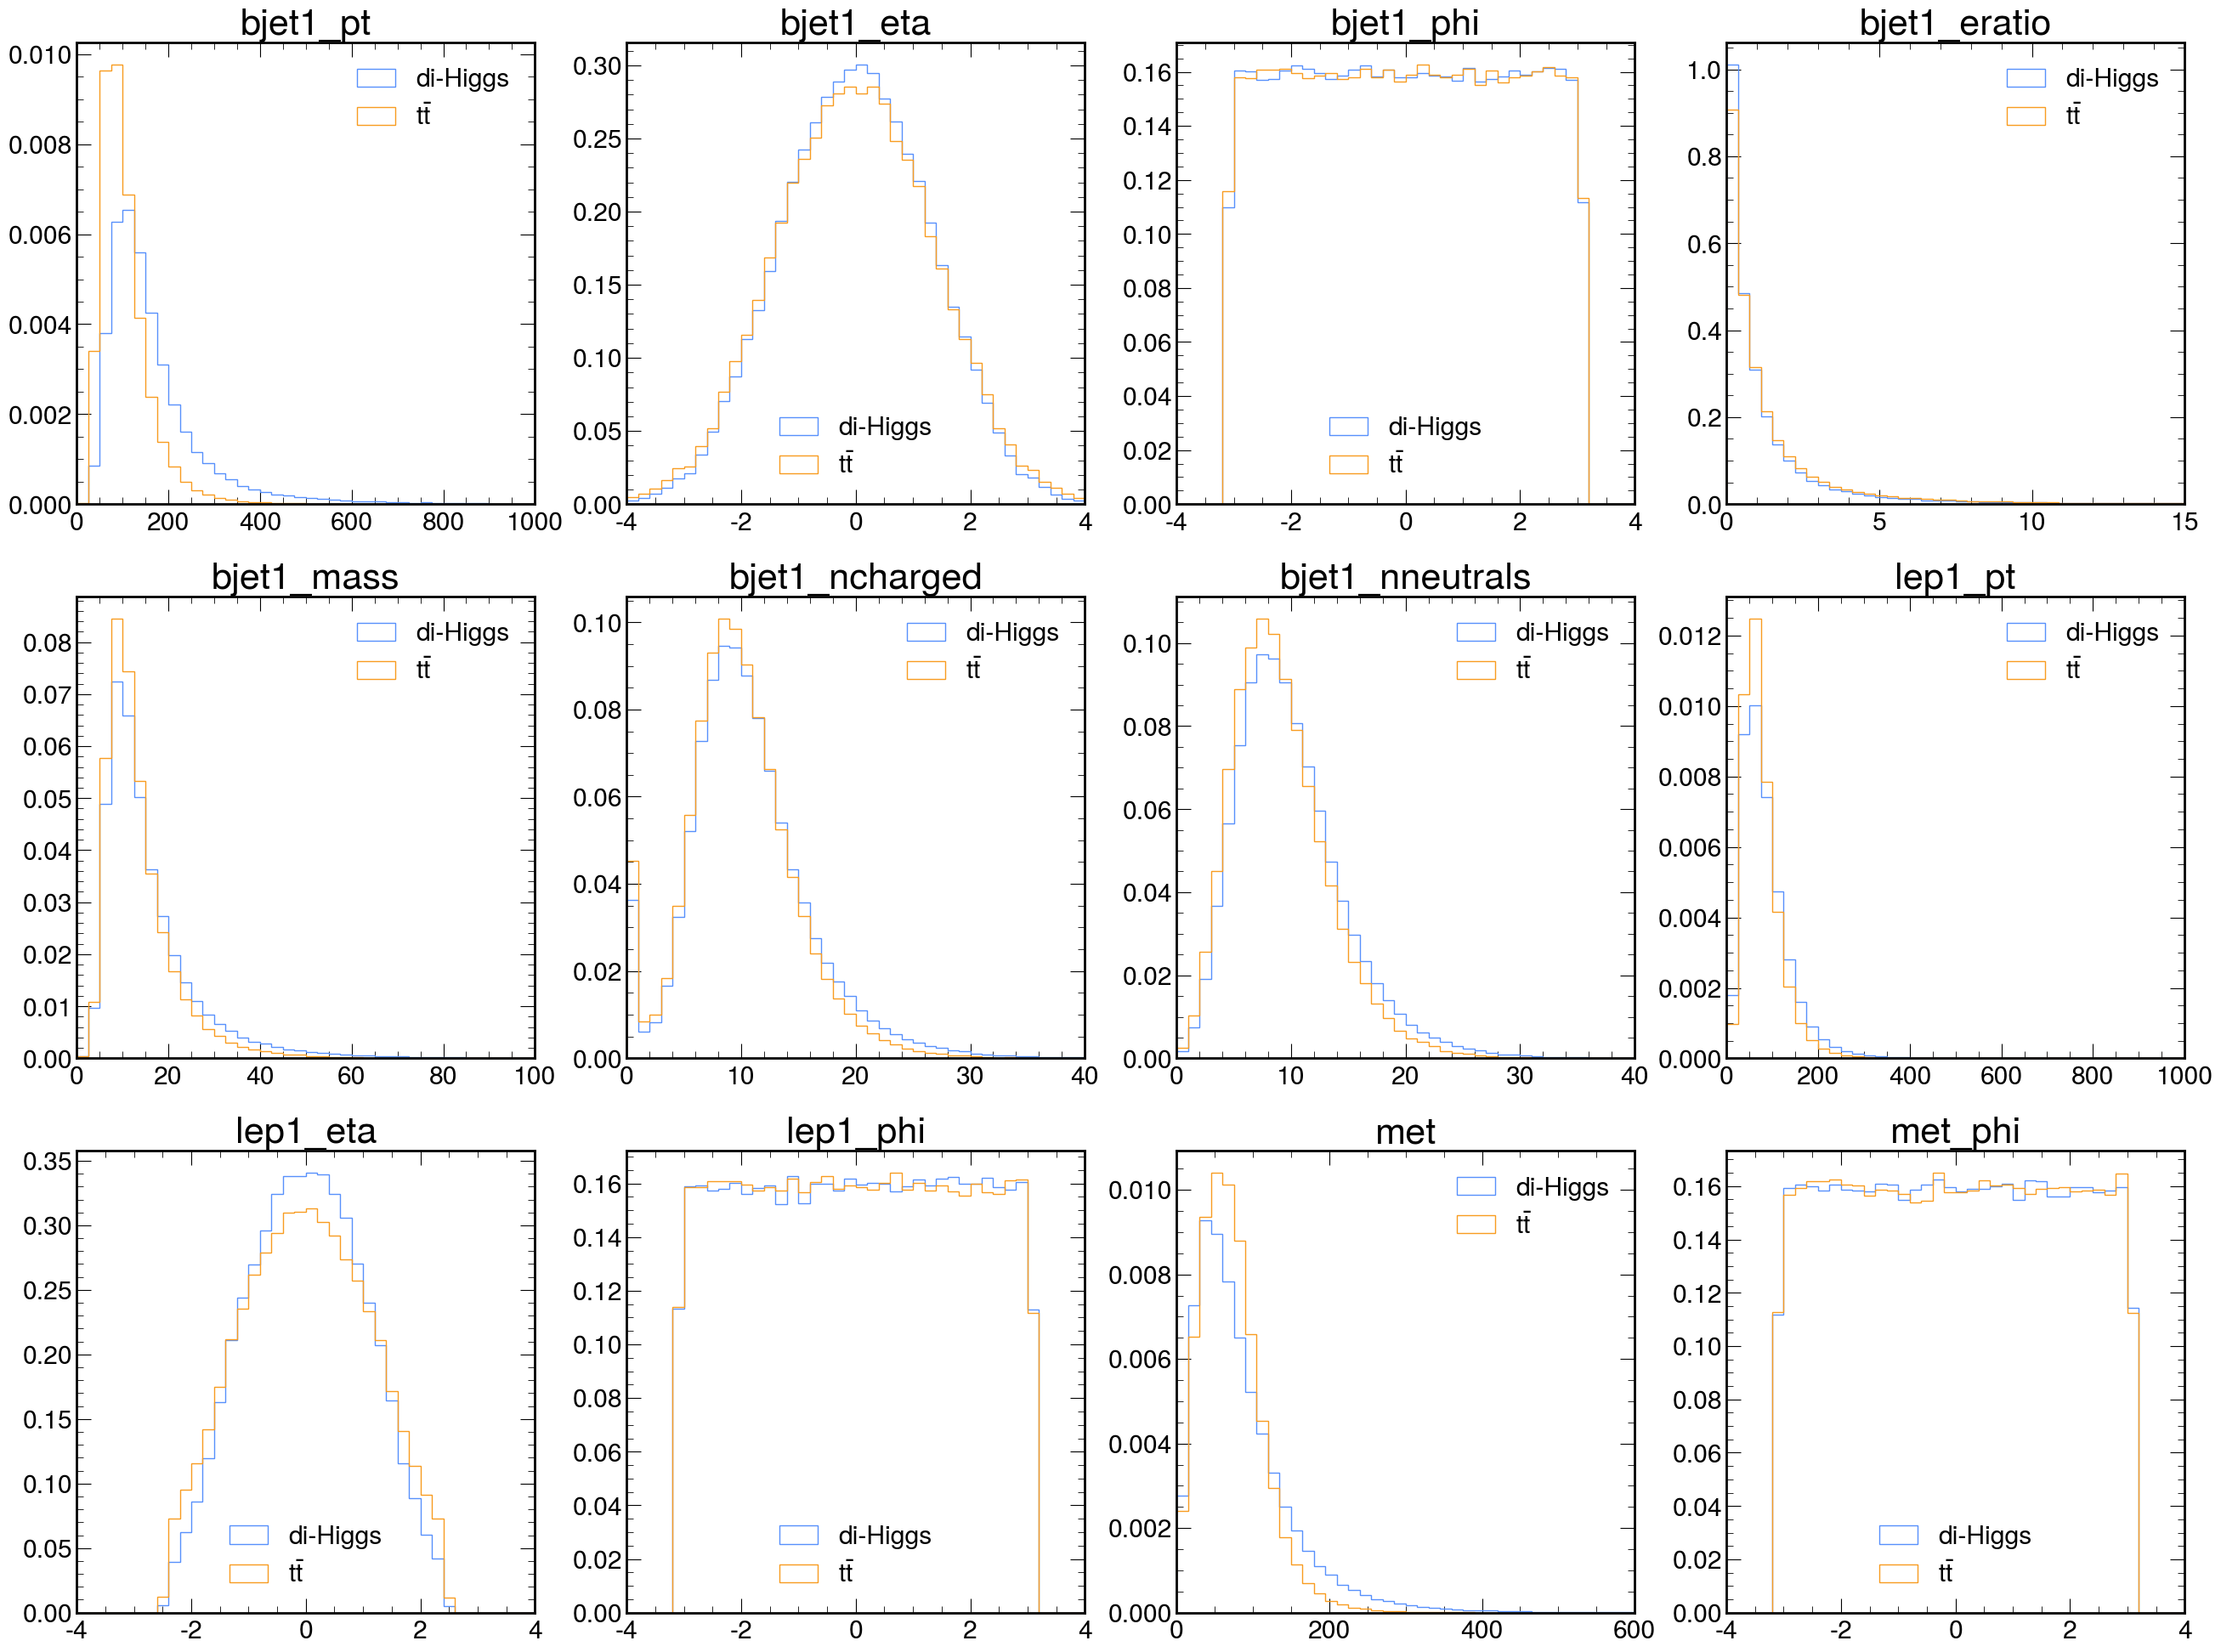

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plotinfo = [ # varname, nbin, xmin, xmax
    ('bjet1_pt', 40, 0, 1000),
    ('bjet1_eta', 40, -4, 4),
    ('bjet1_phi', 40, -4, 4),
    ('bjet1_eratio', 40, 0, 15),
    ('bjet1_mass', 40, 0, 100),
    ('bjet1_ncharged', 40, 0, 40),
    ('bjet1_nneutrals', 40, 0, 40),
    ('lep1_pt', 40, 0, 1000),
    ('lep1_eta', 40, -4, 4),
    ('lep1_phi', 40, -4, 4),
    ('met', 40, 0, 600),
    ('met_phi', 40, -4, 4),
]
plt.figure(figsize=(32, 24))
for i, (varname, nbin, xmin, xmax) in enumerate(plotinfo):
    plt.subplot(3, 4, i+1)
    bins = np.linspace(xmin, xmax, nbin+1)
    plt.hist(dihiggs[varname], histtype="step", bins=bins, label="di-Higgs", density=True)
    plt.hist(ttbar[varname], histtype="step", bins=bins, label="$t\\bar{t}$", density=True)
    plt.legend()
    plt.xlim(xmin, xmax)
    plt.title(varname)

注意到，从单个物理对象来看，区分度并不显著

但是，如果我们考虑多个物理对象之间的关联，情况是否会得到改善？

Text(0.5, 1.0, '$\\Delta\\eta_{l_1,l_2}$')

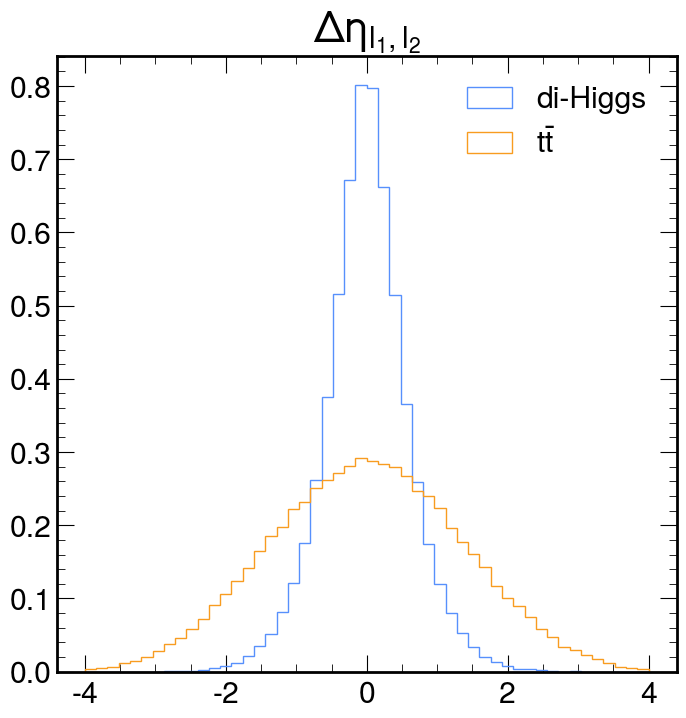

In [4]:
plt.figure(figsize=(8, 8))
plt.hist(dihiggs['lep1_eta'] - dihiggs['lep2_eta'], histtype="step", bins=np.linspace(-4,4,50+1), label="di-Higgs", density=True)
plt.hist(ttbar['lep1_eta'] - ttbar['lep2_eta'], histtype="step", bins=np.linspace(-4,4,50+1), label=r"$t\bar{t}$", density=True)
plt.legend()
plt.title(r"$\Delta\eta_{l_1,l_2}$")

可以发现，di-Higgs过程因为产生的两个 W 玻色子都来源于 H，其衰变的轻子会更接近；而对于 ttbar 过程，因为两个 W 各自来源与两个 top quark，更倾向于“背靠背”。

可见，如果我们能够利用机器学习技术，同时将多个动力学变量纳入分析，就可以利用这些动力学变量之间的关联更加有效率的提取信号。


### 准备数据集

In [8]:
X = df_raw[['bjet1_pt', 'bjet1_eta', 'bjet1_phi',
       'bjet1_eratio', 'bjet1_mass', 'bjet1_ncharged', 'bjet1_nneutrals',
       'bjet2_pt', 'bjet2_eta', 'bjet2_phi', 'bjet2_eratio', 'bjet2_mass',
       'bjet2_ncharged', 'bjet2_nneutrals', 'lep1_pt', 'lep1_phi', 'lep1_eta',
       'lep1_charge', 'lep1_type', 'lep2_pt', 'lep2_phi', 'lep2_eta',
       'lep2_charge', 'lep2_type', 'met', 'met_phi']] # 有没有更简单的写法？
y = df_raw[['is_sig', 'is_bkg']] 

让我们先将数据集一分为三，构建训练、验证、测试 (training/validation/testing) 样本（以下的训练任务还不会用到验证集）。利用Sklearn提供的函数，按照 80/10/10% 来区分三类数据集:

In [9]:
from sklearn.model_selection import train_test_split
X_train, _X_valtest, y_train, _y_valtest = train_test_split(X, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(_X_valtest, _y_valtest, test_size=0.2)

## 用线性模型简单测试

我们首先考虑用逻辑回归来解决这个分类问题：

In [12]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, penalty=None, max_iter=1000).fit(X_train, y_train['is_sig'])
clf.score(X_val, y_val['is_sig'])

/home/olympus/licq/utils/miniconda3/envs/weaver-uproot5/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6945833333333333

In [13]:
test_score = clf.predict_proba(X_test)
test_score_sig = test_score[y_test['is_sig']][:, 1]
test_score_bkg = test_score[y_test['is_bkg']][:, 1]

(0.0, 1.0)

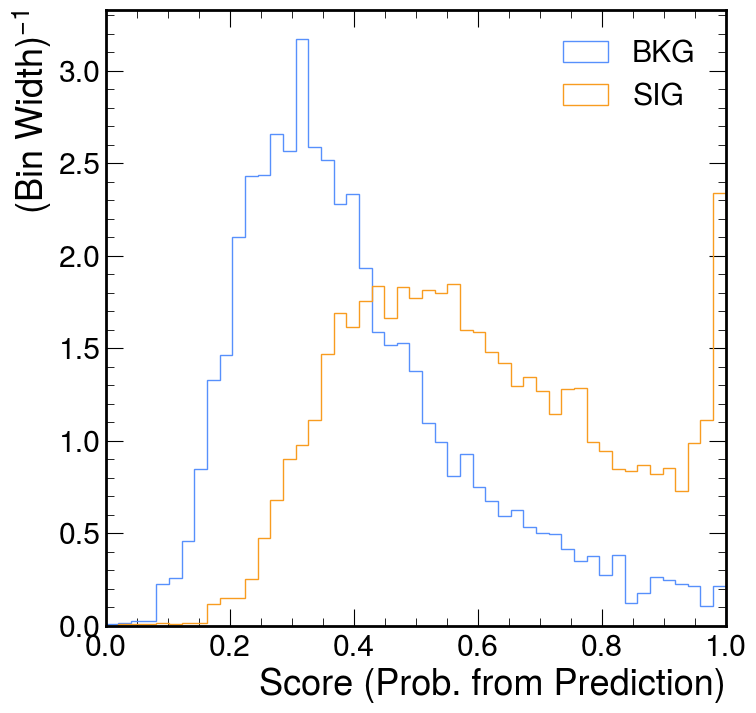

In [15]:
plt.figure(figsize=(8, 8))
hist_bkg = plt.hist(test_score_bkg, label="BKG", histtype="step", bins=np.linspace(0,1), density=True)
hist_sig = plt.hist(test_score_sig, label="SIG", histtype="step", bins=np.linspace(0,1), density=True)
plt.xlabel("Score (Prob. from Prediction)")
plt.ylabel("(Bin Width)$^{-1}$")
plt.legend()
plt.xlim(0,1)

可以看到，逻辑回归的可以起到一定的区分作用，但是分离效果并不是很好。

如何更加坚实的评价这一结果？

### ROC 曲线和 AUC

对于一个分类问题来说，最终我们往往需要为模型报告的分数设定一个阈值。按照是否通过阈值，可以将样本分为两类。那么，在分类中，就会有**信号样本被分成信号样本的概率（True Positive Rate, TPR）** 和 **背景样本被分为信号样本的概率（False Positive Rate, FPR）**。

实际的阈值选取往往面对两难的局面：阈值过低，**FPR**会升高，阈值过高，**TPR**又会降低。

因此，在评价分类模型时，往往会使用 **接收者操作特征曲线(Receiver Operating Characteristic curve，或者叫ROC曲线）** 来进行评价。这条曲线的得到方法如下：
1. 每个阈值 **Th**，都对应着一个 **TPR** 和 **FPR**
2. 将**Th**在[0,1]间变动，对应的二维数组 **（TPR,FPR）** 可以画出一条曲线，即为**ROC**曲线

RuntimeError: Requested MovieWriter (ffmpeg) not available

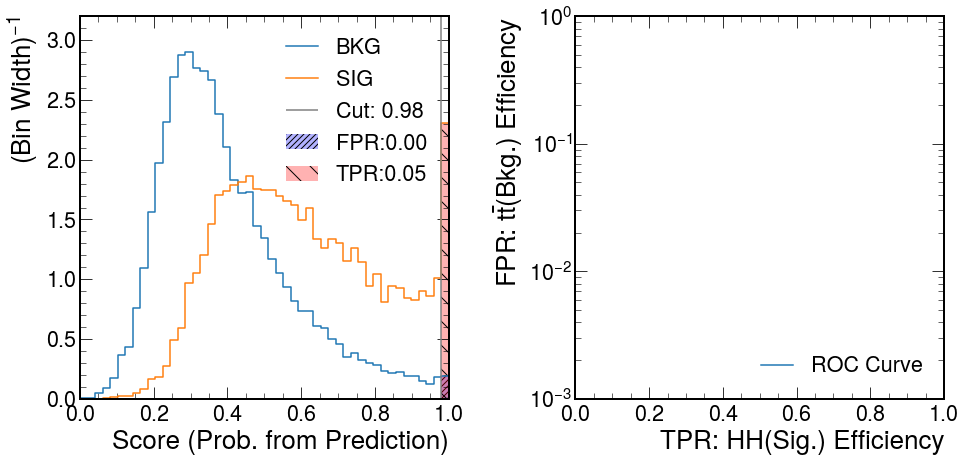

In [16]:
# 这里我们做一个动画，来展示ROC曲线的含义

edges = hist_bkg[1]
nedge = len(edges)
fpr = []
tpr = []

fig = plt.figure(figsize=(14,7), tight_layout=True)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

import matplotlib.animation as animation
from IPython import display

def update_hist(ie):
    
    ax1.cla()
    ax2.cla()
    
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 3.2)
    ax2.set_yscale('log'); ax2.set_xlim(0, 1); ax2.set_ylim(1e-3, 1)
    
    edge = edges[:-1][::-1][ie]

    ax1.step(edges, [0] + [i for i in hist_bkg[0]], label = "BKG")
    ax1.step(edges, [0] + [i for i in hist_sig[0]], label = "SIG")
    
    ax1.vlines(edge,0,5,colors="grey", label = f"Cut: {edge:.2f}")
    
    
    fpr.append(hist_bkg[0][nedge-ie-2:].sum() / hist_bkg[0].sum())
    fpr_tmp = hist_bkg[0][nedge-ie-2:].sum() / hist_bkg[0].sum()
    tpr.append(hist_sig[0][nedge-ie-2:].sum() / hist_sig[0].sum())
    tpr_tmp = hist_sig[0][nedge-ie-2:].sum() / hist_sig[0].sum()
    
    ax1.bar((edges[nedge-ie-2:-1] + edges[nedge-ie-1:])/2, hist_bkg[0][nedge-ie-2:], width=edges[0]-edges[1],
            align="center", color="blue", hatch = '////', alpha=0.3, label=f"FPR:{fpr_tmp:.2f}")
    ax1.bar((edges[nedge-ie-2:-1] + edges[nedge-ie-1:])/2, hist_sig[0][nedge-ie-2:], width=edges[0]-edges[1],
            align="center", color="red", hatch='\\', alpha=0.3, label=f"TPR:{tpr_tmp:.2f}")
    ax2.plot(tpr, fpr, label="ROC Curve")
    
    ax1.legend()
    ax2.legend(loc="lower right")
    ax1.set_xlabel("Score (Prob. from Prediction)")
    ax1.set_ylabel("(Bin Width)$^{-1}$")
    ax2.set_xlabel("TPR: HH(Sig.) Efficiency")
    ax2.set_ylabel("FPR: $t\\bar{t}$(Bkg.) Efficiency")

update_hist(0)
anim = animation.FuncAnimation(fig, update_hist, frames=range(49), repeat=False)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

# 如果在高能所集群运行，视频生成程序可能有问题。可以直接看下面导出的 GIF。

<img src="figures/roc-animation.gif" alt="Drawing" width=900/>

在Sklearn里有一些包装好的函数可以方便的画出**ROC**曲线。下面我们分别画出 FPR (y轴) 为线性轴和对数轴两种情形下的 ROC 曲线。

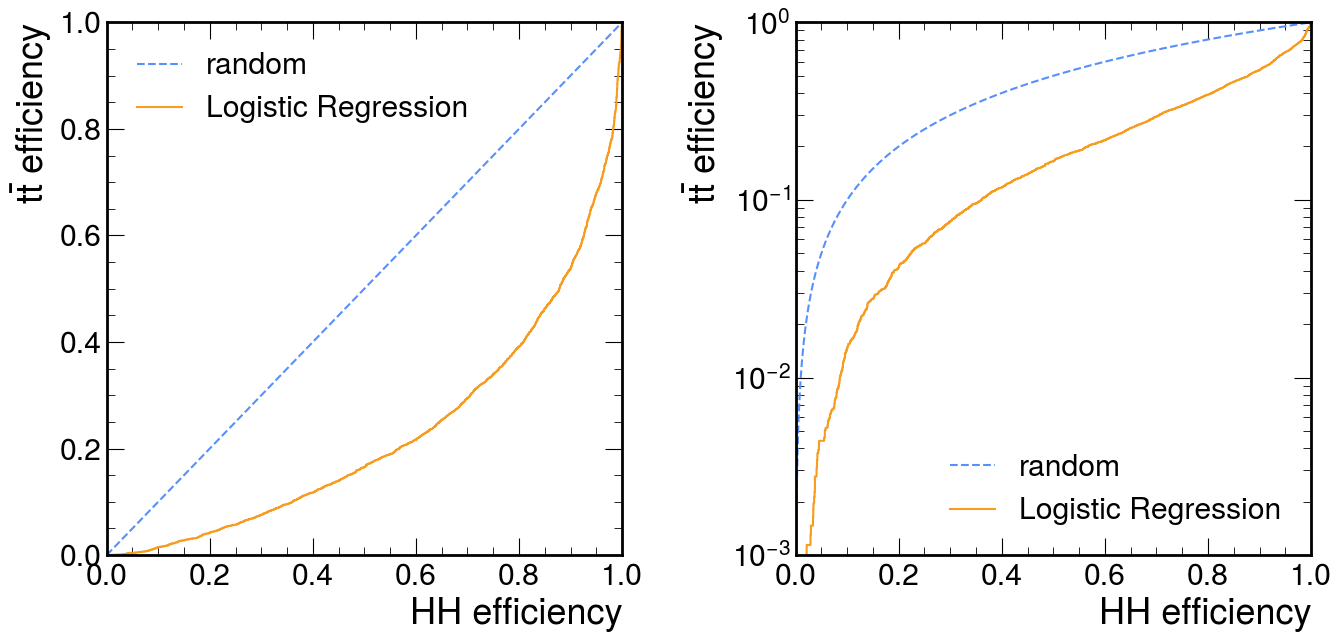

In [21]:
## 计算 ROC 曲线上关键点对应的 FPR, TPR

import sklearn.metrics as m
fpr_clf, tpr_clf, _thres = m.roc_curve(y_test['is_sig'],test_score[:,1])

## 作图
f = plt.figure(figsize=(14, 7), tight_layout=True)
ax1 = f.add_subplot(1,2,1)
ax2 = f.add_subplot(1,2,2)

for ax, ax_type in zip([ax1, ax2], ['linear', 'log']):
    ax.cla()
    ax.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), '--', label='random')
    ax.plot(tpr_clf, fpr_clf, label='Logistic Regression')
    if ax_type == 'linear':
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
    elif ax_type == 'log':
        ax.set_xlim(0, 1)
        ax.set_ylim(1e-3, 1)
        ax.set_yscale('log')
    ax.set_xlabel('HH efficiency', ha='right', x=1.0)
    ax.set_ylabel(r'$t\bar{t}$ efficiency', ha='right', y=1.0)
    ax.legend()

其中"random"线，是考虑我们给每个样本一个[0,1]间的均等的随机概率，这样的话，无论阈值多少，我们预期的**TPR**和**FPR**将相等（例如当阈值为**0.4**时，因为分数是随机的，**TPR**=**FPR**=**(1-0.4)**=**0.6**）。

所以，从ROC曲线上来看，逻辑回归的确起到了提高信号效率的作用。表现在信号通过率**TPR**相近的情况下，逻辑回归的误判率**FPR**更小。（在随机概率的曲线下方）
> 对于背景样本来说，判断正确的概率是**True Negative Rate, TNR**，对于二分类问题，自然有**TNR = 1-FPR**，因此，另一种ROC曲线的等价画法，是画出**（TPR，TNR）** 曲线，这样的话，**ROC**曲线下方的面积 **( Area Under Curve, AUC)** 越大越好，**AUC** 也是一种常见的评价分类模型效果的指标。

## BDT 模型的训练

若要尽可能的从背景中挖掘出信号过程，仅仅依靠动力学变量间的线性关系是远远不够的，我们需要向前迈进一步。

我们使用树模型。梯度提升决策树（Gradient Boosting Decision Tree，GBDT）和 XGBoost 是高能物理中的常用方法。鉴于 XGBoost 的优越性能，并且高能物理的工作流越发 python 化，后者已经越发常用。接下来我们将以 XGBoost 为例进行讲解：

In [16]:
from xgboost import XGBClassifier
xgbc = XGBClassifier(eval_metric="logloss").fit(X_train, y_train['is_sig'])

In [17]:
test_score_xgb = xgbc.predict_proba(X_test)
test_score_xgb_sig = test_score_xgb[y_test['is_sig']][:,1]
test_score_xgb_bkg = test_score_xgb[y_test['is_bkg']][:,1]

(0.0, 1.0)

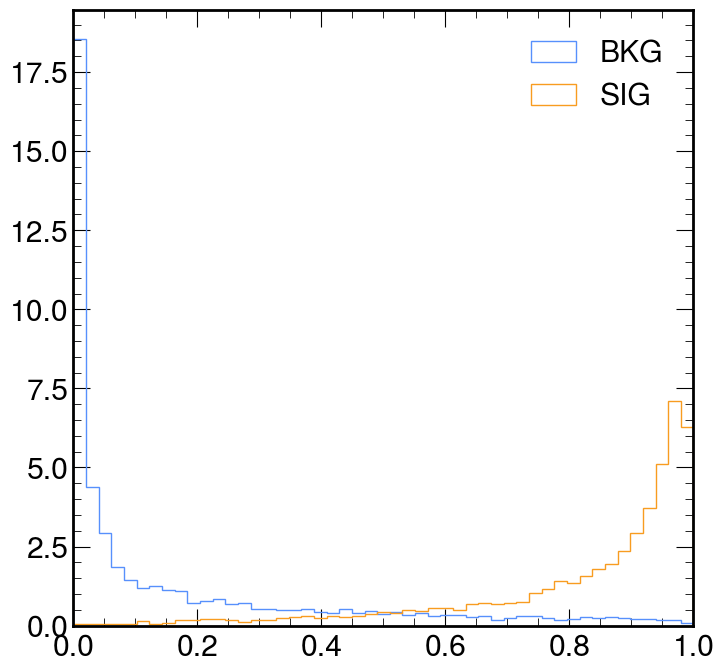

In [19]:
plt.figure(figsize=(8, 8))

plt.hist(test_score_xgb_bkg, label="BKG", histtype="step", bins=np.linspace(0,1), density=True)
plt.hist(test_score_xgb_sig, label="SIG", histtype="step", bins=np.linspace(0,1), density=True)
plt.legend()
plt.xlim(0,1)

可以发现，即使直接使用默认设置，XGBoost也能够给出惊艳的分类效果。

下面记录一些常用的XGBoost的可调参数：

1. `learning_rate`：XGBoost 是一个提升算法，对于残差，虽然 XGBoost 采用的策略并不是简单的基于梯度的优化，但是仍然有着类似的概念，因此，需要有一个参数控制每一步迭代的“步长”
2. XGBoost是一个树模型，因此，对于树本身的调节也是重要的：如最大深度 `max_depth`，或者是分叉的节点（称为“leaf”）的个数 `max_leaf_nodes`。一般来说，这些参数越小约不容易过拟合，但也不宜过小从而树模型的表达能力不够强。
3. 此外，还有一些与残差（更一般的说法是损失函数）与训练相关的参数，可以查阅[相关文档](https://xgboost.readthedocs.io/en/stable/)

下面让我们画出ROC曲线：

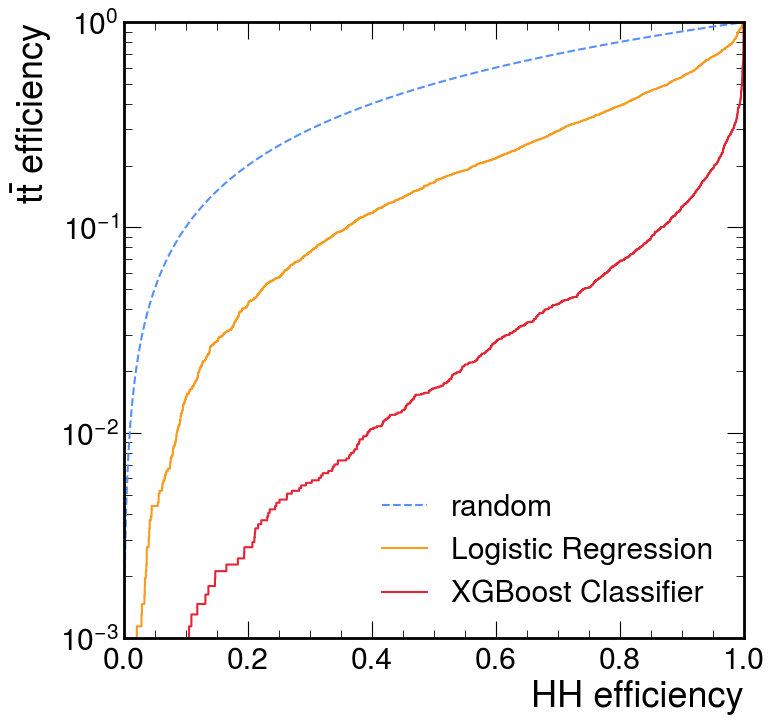

In [22]:
import sklearn.metrics as m
fpr_xgb, tpr_xgb, _thres = m.roc_curve(y_test['is_sig'], test_score_xgb[:,1])

f, ax = plt.subplots(figsize=(8, 8))

ax.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), '--', label='random')
ax.plot(tpr_clf, fpr_clf, label='Logistic Regression')
ax.plot(tpr_xgb, fpr_xgb, label='XGBoost Classifier')

ax.set_yscale('log'); ax.set_xlim(0, 1); ax.set_ylim(1e-3, 1)
ax.set_xlabel('HH efficiency', ha='right', x=1.0); ax.set_ylabel(r'$t\bar{t}$ efficiency', ha='right', y=1.0)
ax.legend()


可见，XGBoost 的分类性能出色。最后，我们来试图解读一下XGBoost做了什么；我们希望检查下，哪些输入特征起到了重要作用？

使用 XGBoost 的 `plot_importance` 可以绘制不同特征对分类重要程度的量表。XGBoost 支持多种特征重要性度量方式，如 weight、gain、cover、’otal_cover 和total_gain，分别反映了不同角度的特征重要性。

> - `weight`: 特征在树中的平均权重。
> - `gain`: 特征被用作分割点时的平均增益。
> - `cover`: 特征被用作分割点时的平均覆盖率。
> - `total_cover`: 特征被用作分割点时的总覆盖率。
> - `total_gain`: 特征被用作分割点时的总增益。

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

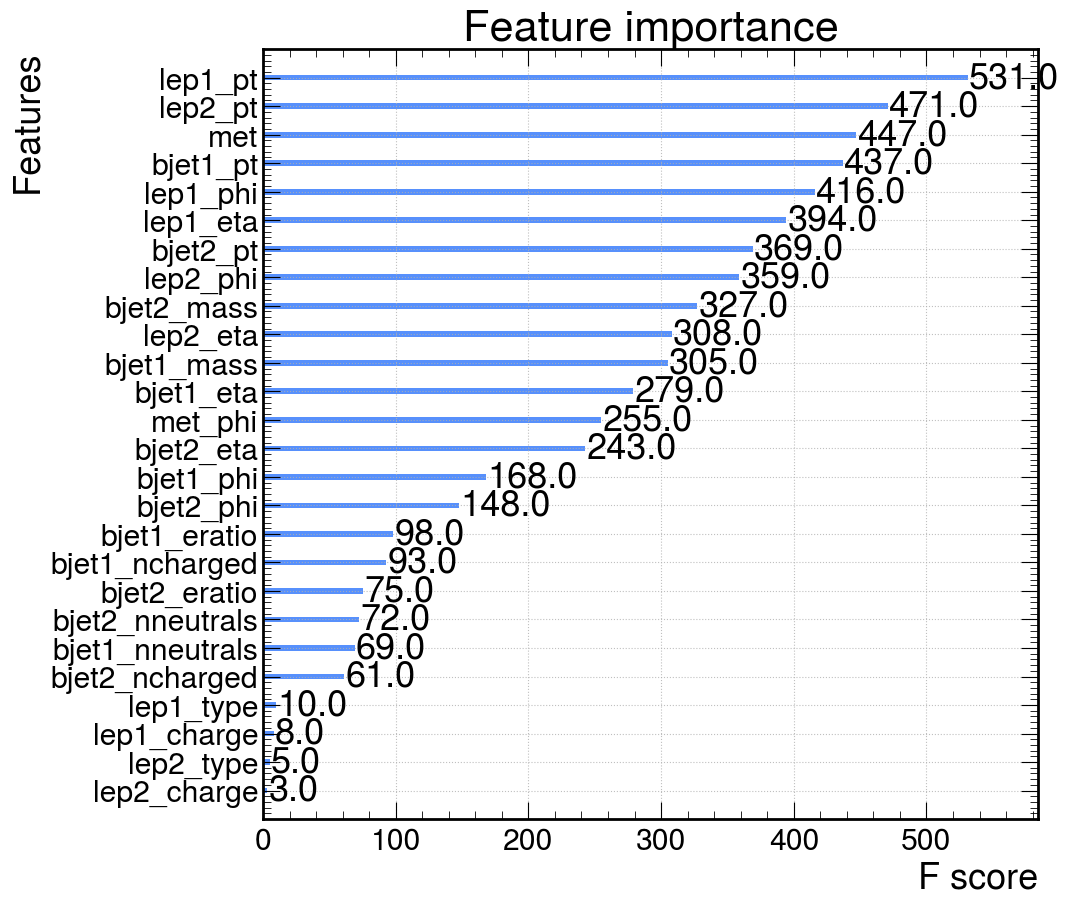

In [23]:
from xgboost import plot_importance
plot_importance(xgbc)

> F score是一种在决策树模型中常用的判断“特征”（在我们这儿对应着动力学变量）重要程度的指标，其等于这一个特征在整个分类过程中的出现次数。

最后我们储存一下 ROC 曲线的数据，方便下一节使用：

In [25]:
os.makedirs('data', exist_ok=True)
np.savetxt("data/roc_lr.dat", [tpr_clf, fpr_clf])
np.savetxt("data/roc_xgb.dat", [tpr_xgb, fpr_xgb])